In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
import mlflow
import mlflow.keras
import mlflow.tensorflow

plt.style.use("ggplot")

In [0]:
working_path = "dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/"

display(dbutils.fs.ls(working_path))

path,name,size
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/Features.csv,Features.csv,107657595
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/NewFeaturesFinal.csv,NewFeaturesFinal.csv,116243380
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/UnseenFeatures14days.csv,UnseenFeatures14days.csv,10914576
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_test_res.csv,X_test_res.csv,20106033
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_train_res-1.csv,X_train_res-1.csv,40679637
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_train_res.csv,X_train_res.csv,59024700
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_20_medium.csv,X_tsf_20_medium.csv,217685299
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_20_medium_with_index.csv,X_tsf_20_medium_with_index.csv,218615307
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_unseen_20_medium_index.csv,X_tsf_unseen_20_medium_index.csv,2092565
dbfs:/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_window_20.csv,X_tsf_window_20.csv,35669827


In [0]:
# Load vehicle list and nonfailure failure set
seen_vehicles = pd.read_csv('/dbfs/FileStore/shared_uploads/mtaruno@u.rochester.edu/vehicle_list.csv')
seen_dpf_normal = []
seen_dpf_failure = []

for i, e in seen_vehicles.iterrows():
    if(e.dpf_failure == 'No'):
        seen_dpf_normal.append(e.platform_id)
    else:
        seen_dpf_failure.append(e.platform_id)
len(seen_dpf_normal)

Out[99]: 69

In [0]:
# unseen_vehicles = pd.read_csv('/dbfs/FileStore/shared_uploads/mtaruno@u.rochester.edu/unseen_vehicle_list.csv')
# unseen_vehicles = unseen_vehicles.drop([26])
# unseen_vehicles.platform_id

In [0]:
# unseen_dpf_normal = []
# unseen_dpf_failure = []

# for i, e in unseen_vehicles.iterrows():
#     if(e.dpf_failure == 'No'):
#         unseen_dpf_normal.append(e.platform_id)
#     else:
#         unseen_dpf_failure.append(e.platform_id)
# len(unseen_dpf_normal)

In [0]:
## All functions for labeling and generating training/testing set

window_size = 8

def generate_windows(data, ws=window_size, scaler=StandardScaler):
    ll = len(data)
    label = data.label.tolist()
    data_copy = data.copy(deep=True)
    try:
      data_copy = data_copy.drop('window_end',axis=1)
      data_copy = data_copy.drop('label', axis=1)
    except:
      print("Window_end and label column not found in the input data")
      
    dd = scaler().fit_transform(data_copy)
    X = []
    y = []
    label_windowed = []
    
    if ws>ll:
        print(f'window size bigger than data, return null. ll:{ll}, ws:{ws}')
        return None,None,None
      
    for i in range(0, (ll - ws)):
        X.append(dd[i:i+ws])
        y.append(dd[i:i+ws])
        label_windowed.append(label[i:i+ws])
    
    return X, y, label_windowed
  
def generate_s_windows(data, ws=window_size, scaler=StandardScaler):
  if(type(data) != pd.core.frame.DataFrame):
    print("Require 2D dataframe only with dpf_failure data")
    return null
  ll = len(data)
  label = data.label.tolist()
  data_copy = data.copy(deep=True)
  try:
    data_copy = data_copy.drop('platform_id',axis=1)
  except: 
    print('platform_id not found in original dataset. Skip dropping...')
  try:
    data_copy = data_copy.drop('window_end',axis=1)
  except:
    print("Window_end not found in the input data")
  try:
    data_copy = data_copy.drop('label', axis=1)
  except:
    print('label not found in the input data')
  
  dd = scaler().fit_transform(data_copy)
  X = []
  y = []
  label_windowed = []
  
  if ws>ll:
      print('window size bigger than data, return null')
      return None,None,None
      
  for i in range(0, (ll - ws)):
      X.append(dd[i:i+ws])
      y.append(dd[i:i+ws])
      label_windowed.append(1)

  return X, y, label_windowed

# this is just to generate a histogram for the 0s, 1s, and 2s.
def generate_single_labels(data, ws=window_size):
    ll = len(data)
    label = data.label.tolist()
    label_windowed = []
    for i in range(0, (ll - ws)):
        label_windowed.append(label[i:i+ws])
    
    return label_windowed

# same
def generate_labels(data, ws=window_size, failure = dpf_failure):
    labels_windowed = []
    for i in failure: # Add each truck to training data
        labels = generate_single_labels(data.loc[i,:])
        labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    return true_labels

def generate_training(data, ws=window_size, normal = dpf_normal,random=0):
    Xs = []
    Ys = []
    # Training data does not need label
    for i in normal: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None): # When ws smaller than or equal to the data len
            Xs += X
            Ys += y
    X_tr, X_ts, y_tr, y_ts = [np.array(x) for x in train_test_split(Xs, Ys,random_state=random)]
    return (X_tr, y_tr, X_ts, y_ts)

def generate_all_training(data, ws=window_size, normal = dpf_normal):
    Xs = []
    Ys = []
    # Training data does not need label
    for i in normal: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xs += X
            Ys += y
    x1, x2 = [np.array(x) for x in (Xs,Ys)]
    return (x1,x2)
  
def generate_total_training(data,ws=window_size,normal=dpf_normal,failure=dpf_failure):
    Xs = []
    Ys = []
    # Training data does not need label
    for i in normal: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xs += X
            Ys += y

    labels_windowed = []
    Xsf = []
    for i in failure: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xsf += X
            labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xsf,true_labels)
    
    to_remove = []
    for i in range(0,len(true_labels_updated)):
        if true_labels_updated[i]==1:
            to_remove.append(i) #record the positions to remove
    print("To remove: ",len(to_remove))
    for i in sorted(to_remove, reverse = True):
        del X_updated[i]
        
    x_total = Xs + X_updated
    
    y1, y2 = [np.array(x) for x in (x_total,x_total)]
    return (y1,y2)

def generate_s_training(data, ws=window_size):
    Xs = []
    Ys = []
    for i in data.index.levels[0]:
        X,y,labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xs += X
            Ys += y
    x1, x2 = [np.array(x) for x in (Xs,Ys)]
    return (x1,x2)
  
def generate_testing(data, ws=window_size, failure = dpf_failure, random=0):
    '''
    return: 
        Xtr, Xts - data from the dpf_failure ones
        y_tr, y_ts - labels from the dpf_failure windows
    '''
    Xs = []
    labels_windowed = [] # testing data needs label
    for i in failure: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xs = Xs + X
            labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xs,true_labels)
    
    X_tr, X_ts, y_tr, y_ts = [np.array(x) for x in train_test_split(X_updated, true_labels_updated, random_state=random)]
    #@@!! hopefully, this will distribute the correct label to the correct window after train_test_split
    
    print('last platform_id: ',i)
    return (X_tr, y_tr, X_ts, y_ts)

#@@ I don't want to test if X_updated is mapped correctly to the true_labels, but problems maybe here

def generate_all_testing(data, ws=window_size, failure = dpf_failure): # no train test split
    '''
    returns a tuple of testing data, X mapped to its label
    '''
    Xs = []
    labels_windowed = []
    for i in failure: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xs += X
            labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xs,true_labels)
    
    y1, y2 = [np.array(x) for x in (X_updated,true_labels_updated)]
    return (y1,y2)
  
def generate_total_testing(data, ws=window_size): # no train test split
    '''
    returns a tuple of testing data, X mapped to its label
    '''
    Xs = []
    labels_windowed = []
    for i in vehicles.platform_id.tolist(): # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xs += X
            labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xs,true_labels)
    
    y1, y2 = [np.array(x) for x in (X_updated,true_labels_updated)]
    return (y1,y2)

def generate_single_testing(data,ws=window_size,failure=dpf_failure,whichfail=0):
    Xs = []
    labels_windowed = []
    fail = failure[whichfail]
    print("Which fail: ",whichfail)
    X, y, labels = generate_windows(data.loc[fail,:],ws)
    if (X!=None):
        Xs += X
        labels_windowed += labels
    else:
        print("window size too big for this platform")
        return (None,None)
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xs,true_labels)
    
    y1, y2 = [np.array(x) for x in (X_updated,true_labels_updated)]
    return (y1,y2)

def generate_single_testing_normal(data,ws=window_size,normal=dpf_normal,whichnormal=0):
    Xs = []
    labels_windowed = []
    norm = normal[whichnormal]
    print("Which normal: ",whichnormal)
    X, y, labels = generate_windows(data.loc[norm,:],ws)
    if (X!=None):
        Xs += X
        labels_windowed += labels
    else:
        print("window size too big for this platform")
        return (None,None)
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xs,true_labels)
    
    y1, y2 = [np.array(x) for x in (X_updated,true_labels_updated)]
    return (y1,y2)

def generate_s_testing(data, dataf, ws=window_size):
    Xs = []
    labels_windowed = []
    for i in data.index.levels[0]: # Add each truck to training data
        X, y, labels = generate_windows(data.loc[i,:],ws)
        if (X!=None):
            Xs += X
            labels_windowed += labels
    label_np = [np.array(x) for x in (labels_windowed)]
    true_labels = label_window(label_np)
    X_updated, true_labels_updated = remove_label2(Xs,true_labels)
    
    Xf, yf, labelf = generate_s_windows(dataf,ws)
    
    print(len(Xf))
    print(len(X_updated))
    
    for i in Xf:
        if (i!=None):
            X_updated.append(i)
    for k in labelf:
        if (k!=None):
            true_labels_updated.append(k)
    
    print('y1len:',len(X_updated))
    print('y2len:', len(true_labels_updated))
    y1, y2 = [np.array(x) for x in (X_updated,true_labels_updated)]
    return (y1,y2)
    
def generate_class(a_data, ws = window_size, failure = dpf_failure):
    ll = 0
    dpf_class = []
    
    for i in failure:
        truck_all = a_data.loc[i,:]
        ll = len(truck_all)
        
        
        for j in range(0, (ll-ws)):
#             print(i,j+ws)
#             print(truck_all['Failure'].iloc[j+ws])
            
            if(truck_all['Failure'].iloc[j+ws]==1):
                dpf_class.append(1)
            else:
                dpf_class.append(0)
    return dpf_class
  
def extract_raw(data):
    frames = []
    for i, e in vehicles.iterrows():
        tmp = data[data['platform_id']==e.platform_id]
        try: 
            del tmp['Unnamed: 0']
        except:
            None
        frames.append(tmp)
        
    data_all = pd.concat(frames, axis=0,  keys=vehicles.platform_id.tolist()) # The order of the vehicle.platform_id is the same as tmp's
    return data_all

def extract_trainingdf(data):
    frames = []
    for i, e in vehicles.iterrows():
        tmp = data[data['platform_id']==e.platform_id]
        try: 
            del tmp['Unnamed: 0']
            del tmp['Unnamed: 1']
        except:
            None
        try: 
            del tmp['platform_id']
        except:
            None
        frames.append(tmp)
        
    data_all = pd.concat(frames, axis=0,  keys=vehicles.platform_id.tolist()) # The order of the vehicle.platform_id is the same as tmp's
    return data_all

def label_window(label):
    ''' This function is to generate correct label for each window in the training data. 
    input: 
        label - the set of labels for all data (2D array)
    
    '''
    true_label = []
    
    for i in range(0,len(label)):
        if label[i].any():
            check_if_all_1s = True
            for q in range(0,len(label[i])):
                if q!=len(label[i])-1 and label[i][q]==1 and label[i][q+1]==0: # case of 0001100
#                     print(f"2: over dpf_failure. Window:{i}, Which:",q)
                    true_label.append(2)
                    check_if_all_1s = False
                    break
            if(check_if_all_1s):
#                 print(f"1: 14 days within dpf_failure. Window:{i}, Which:",q)
#                 print('label:',label[i][q])
                true_label.append(1)
        else: 
            true_label.append(0) # Simply all 0s = non-failure
            
#     for i in range(0,len(label)):
#         if label[i].any():
#             true_label.append(2)
#         else:
#             if i!=len(label)-1:
#                 if label[i+1].any():
#                     true_label.append(1)
#                 else:
#                     true_label.append(0)
#             else:
#                 true_label.append(0)
    print("Number of 1s: ",true_label.count(1))
    print("This number should be close to #1s * 14 in tsf_labeled")
    print("Number of 0s: ",true_label.count(0))
    return true_label

def remove_label2(data,label):
    ''' This function is to remove data labeled 2 from a single dataframe

    Returns
    -------
    updated data and label


    '''
    to_remove = []
    for i in range(0,len(data)):
        if label[i]==2:
            to_remove.append(i) #record the positions to remove
    for i in sorted(to_remove, reverse = True):
        del data[i]
        del label[i]
    return data,label

In [0]:
def mse_sum(mse):
    mse_sum=[]
    for i in range(0,mse.shape[0]):
        mse_sum.append(np.sum(mse[i]))
    len(mse_sum)
    return mse_sum

In [0]:
tsf_comp = pd.read_csv("/dbfs/FileStore/shared_uploads/mtaruno@u.rochester.edu/X_tsf_window_20_comprehensive_label.csv")

vehicles = seen_vehicles
dpf_normal = seen_dpf_normal
dpf_failure = seen_dpf_failure

tsf_comp_processed = extract_trainingdf(tsf_comp)
tsf_comp_processed.loc[309450,:].label.tolist().count(1)

Out[54]: 13

In [0]:
# tsf_unseen = pd.read_csv("/dbfs/FileStore/shared_uploads/mtaruno@u.rochester.edu/unseen_X_tsf_window_20_comprehensive_label.csv")
# vehicles = unseen_vehicles
# dpf_normal = unseen_dpf_normal
# dpf_failure = unseen_dpf_failure

# tsf_unseen_processed = extract_trainingdf(tsf_unseen)
# tsf_unseen_processed.head(25)

In [0]:
# unseen_id = tsf_unseen_processed.index.levels[0].tolist()
# set(unseen_id) - set(unseen_vehicles.platform_id.tolist())

In [0]:
# vehicles = unseen_vehicles
# dpf_normal = unseen_dpf_normal
# dpf_failure = unseen_dpf_failure

# tsf_unseen_processed = extract_trainingdf(tsf_unseen)
# tsf_unseen_processed.loc[vehicles.platform_id[34],:].label.tolist().count(1)

In [0]:
wsize = 30
vehicles = seen_vehicles
dpf_normal = seen_dpf_normal
dpf_failure = seen_dpf_failure

X, y = generate_total_training(tsf_comp_processed, wsize)

window size bigger than data, return null. ll:28, ws:30
Number of 1s: 1322
This number should be close to #1s * 14 in tsf_labeled
Number of 0s: 54835
To remove: 1322

In [0]:
# wsize = 3
# vehicles = unseen_vehicles
# dpf_normal = unseen_dpf_normal
# dpf_failure = unseen_dpf_failure

# U, s = generate_total_testing(tsf_unseen_processed, wsize)

In [0]:
train_data = tsf_comp_processed
wsize=30

In [0]:
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

## Dense Layer Autoencoder

In [0]:
# This function needs the shape of the training data.
def create_dense(n):
  '''
  param: 
    nfirst - first layer
    nsecond - second layer
  '''
  encoding_dim = wsize/2
  hidden_dim = wsize/4
  train_shape=X

  input_layer = layers.Input(shape=(X.shape[1], X.shape[2]))
  encoder = layers.Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(n['learning_rate']))(input_layer)
  encoder = layers.Dense(hidden_dim, activation="relu")(encoder)
  decoder = layers.Dense(hidden_dim, activation="relu")(encoder)
  decoder = layers.Dense(encoding_dim, activation="relu")(decoder)
  decoder = layers.Dense(X.shape[2], activation="linear")(decoder)
  dense = Model(inputs=input_layer, outputs=decoder)
  return dense

In [0]:
from hyperopt import fmin, hp, tpe, STATUS_OK, SparkTrials

# This function is taking the input of train_shape
def run_dense(n):
  
  # Log run information with mlflow.tensorflow.autolog()
  mlflow.tensorflow.autolog()
  
  model = create_dense(n)
 
  # Select optimizer
  optimizer_call = getattr(tensorflow.keras.optimizers, n["optimizer"])
  optimizer = optimizer_call(learning_rate=n['learning_rate'])
#   optimizer = optimizer_call(learning_rate=0.01)

  # Compile model
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=["mse"])
  
#   X, y = generate_s_training(train_data,int(n['window_size']))
  
  history = model.fit(X, y, validation_split=.2, epochs=int(n['epochs']), verbose=1, callbacks=[early_stop])
#   history = model.fit(X, y, validation_split=.2, epochs=10, verbose=2, callbacks=[early_stop])

  # Evaluate the model
  score = model.evaluate(X, y, verbose=0)
  return {"loss": score[0], "status": STATUS_OK}

In [0]:
#Hyperopt search space
space_dense = {
  "epochs": hp.quniform("epochs", 10,100,1),
  "learning_rate": hp.loguniform("learning_rate", -5, 0),
  "optimizer": hp.choice("optimizer", ["Adadelta", "Adam"])
 }

In [0]:
spark_trials = SparkTrials()
with mlflow.start_run():
  best_hyperparam50 = fmin(fn=run_dense, 
                         space=space_dense, 
                         algo=tpe.suggest,
                         max_evals=30, 
                         trials=spark_trials)
mlflow.end_run()

Because the requested parallelism was None or a non-positive value, parallelism will be set to (8), which is Spark's default parallelism (8), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/30 [00:00<?, ?trial/s, best loss=?]

In [0]:
import hyperopt
print(hyperopt.space_eval(space_dense, best_hyperparam50))

{'epochs': 99.0, 'learning_rate': 0.006938767964929616, 'optimizer': 'Adam'}

### Tuned Dense Autoencoder:

In [0]:
# Following the guide Prof. Lloyd provided
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model

nb_epoch = 99
encoding_dim = wsize/2
hidden_dim = wsize/4
learning_rate = 0.006938767964929616

input_layer = layers.Input(shape=(X.shape[1], X.shape[2]))
encoder = layers.Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = layers.Dense(hidden_dim, activation="relu")(encoder)
decoder = layers.Dense(hidden_dim, activation="relu")(encoder)
decoder = layers.Dense(encoding_dim, activation="relu")(decoder)
decoder = layers.Dense(X.shape[2], activation="linear")(decoder)
dense = Model(inputs=input_layer, outputs=decoder)
dense.summary()

Model: "model"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
input_1 (InputLayer) [(None, 30, 18)] 0 
_________________________________________________________________
dense (Dense) (None, 30, 15) 285 
_________________________________________________________________
dense_1 (Dense) (None, 30, 7) 112 
_________________________________________________________________
dense_2 (Dense) (None, 30, 7) 56 
_________________________________________________________________
dense_3 (Dense) (None, 30, 15) 120 
_________________________________________________________________
dense_4 (Dense) (None, 30, 18) 288 
=================================================================
Total params: 861
Trainable params: 861
Non-trainable params: 0
_________________________________________________________________

In [0]:
optimizer_call = getattr(tensorflow.keras.optimizers, 'Adam')
optimizer = optimizer_call(learning_rate=0.006938767964929616)
  
dense.compile(metrics=['mse'],
                    loss='mse',
                    optimizer='adam')
history = dense.fit(X, y,
                    epochs=nb_epoch,
                    shuffle=True,
                    validation_data=(X, y),
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/99
 1/3062 [..............................] - ETA: 41:43 - loss: 2.1982 - mse: 0.9085 26/3062 [..............................] - ETA: 6s - loss: 2.0377 - mse: 0.9128  52/3062 [..............................] - ETA: 6s - loss: 1.9337 - mse: 0.8722 73/3062 [..............................] - ETA: 6s - loss: 1.8686 - mse: 0.8517 98/3062 [..............................] - ETA: 6s - loss: 1.8022 - mse: 0.8338 122/3062 [>.............................] - ETA: 6s - loss: 1.7442 - mse: 0.8193 147/3062 [>.............................] - ETA: 6s - loss: 1.6891 - mse: 0.8059 173/3062 [>.............................] - ETA: 6s - loss: 1.6364 - mse: 0.7931 199/3062 [>.............................] - ETA: 6s - loss: 1.5886 - mse: 0.7813 226/3062 [=>............................] - ETA: 5s - loss: 1.5432 - mse: 0.7700 253/3062 [=>............................] - ETA: 5s - loss: 1.5017 - mse: 0.7596 281/3062 [=>............................] - ETA: 5s - loss: 1.4622 - mse: 0.7493 308/3062 [==>...........................] - ETA: 5s - loss: 1.4268 - mse: 0.7397 334/3062 [==>...........................] - ETA: 5s - loss: 1.3950 - mse: 0.7309 361/3062 [==>...........................] - ETA: 5s - loss: 1.3642 - mse: 0.7221 387/3062 [==>...........................] - ETA: 5s - loss: 1.3365 - mse: 0.7141 414/3062 [===>..........................] - ETA: 5s - loss: 1.3096 - mse: 0.7061 441/3062 [===>..........................] - ETA: 5s - loss: 1.2844 - mse: 0.6985 468/3062 [===>..........................] - ETA: 5s - loss: 1.2608 - mse: 0.6912 494/3062 [===>..........................] - ETA: 5s - loss: 1.2393 - mse: 0.6845 522/3062 [====>.........................] - ETA: 5s - loss: 1.2175 - mse: 0.6775 550/3062 [====>.........................] - ETA: 4s - loss: 1.1969 - mse: 0.6708 578/3062 [====>.........................] - ETA: 4s - loss: 1.1775 - mse: 0.6645 606/3062 [====>.........................] - ETA: 4s - loss: 1.1591 - mse: 0.6584 629/3062 [=====>........................] - ETA: 4s - loss: 1.1447 - mse: 

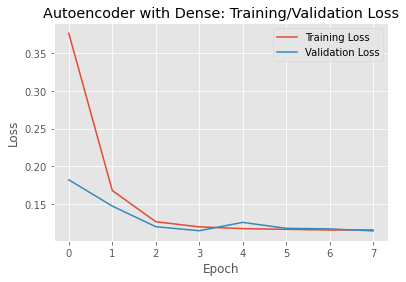

In [0]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder with Dense: Training/Validation Loss")
plt.legend()
plt.show()

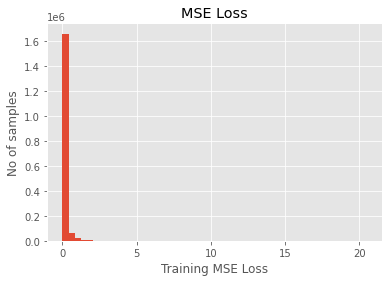

In [0]:
# MSE loss
X_pred = dense.predict(X)
train_mse_loss = np.mean(np.power(X_pred - X,2), axis=1)
train_mse_loss = train_mse_loss.reshape((-1))

plt.hist(train_mse_loss, bins=50)
plt.title("MSE Loss")
plt.xlabel("Training MSE Loss")
plt.ylabel("No of samples")
plt.show()

In [0]:
vehicles = seen_vehicles
dpf_normal = seen_dpf_normal
dpf_failure = seen_dpf_failure

A, l = generate_all_testing(tsf_comp_processed,wsize)
# A, l = generate_single_testing_normal(tsf,window,whichnormal=3)
# A, l = generate_all_testing(tsf,window)
A_pred = dense.predict(A)
mse = np.mean(np.power(A - A_pred, 2), axis=1)
ms = mse_sum(mse)
error_df_test = pd.DataFrame({'Reconstruction_error': ms,'True_class': l})
error_df_test = error_df_test.reset_index()

Number of 1s: 1322
This number should be close to #1s * 14 in tsf_labeled
Number of 0s: 54835

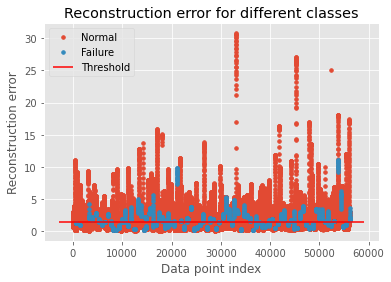

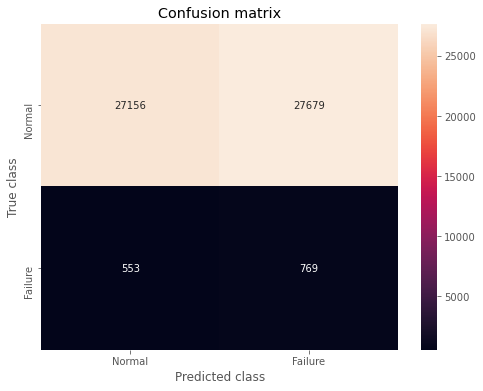

Classification Report for Autoencoder with Dense Layers:
 precision recall f1-score support

 0 0.98 0.50 0.66 54835
 1 0.03 0.58 0.05 1322

 accuracy 0.50 56157
 macro avg 0.50 0.54 0.35 56157
weighted avg 0.96 0.50 0.64 56157


F1 Score:
[0.65797635 0.05166275]

In [0]:
threshold_fixed = 1.39
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Failure" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();
classes = ['Normal','Failure']
y_pred = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print('\nClassification Report for Autoencoder with Dense Layers:')
print(classification_report(error_df_test.True_class, y_pred))
print('\nF1 Score:')
print(f1_score(error_df_test.True_class, y_pred, average = None))

In [0]:
# # Unseen dataset: U, s
# U_pred = dense.predict(U)
# mse = np.mean(np.power(U - U_pred, 2), axis=1)
# ms = mse_sum(mse)
# error_df_test = pd.DataFrame({'Reconstruction_error': ms,'True_class': s})
# error_df_test = error_df_test.reset_index()

In [0]:
# threshold_fixed = 1.34
# groups = error_df_test.groupby('True_class')
# fig, ax = plt.subplots()
# for name, group in groups:
#     ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
#             label= "Failure" if name == 1 else "Normal")

# ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
# ax.legend()
# plt.title("Reconstruction error for different classes")
# plt.ylabel("Reconstruction error")
# plt.xlabel("Data point index")
# plt.show();
# classes = ['Normal','Failure']
# y_pred = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
# conf_matrix = confusion_matrix(error_df_test.True_class, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True class')
# plt.xlabel('Predicted class')
# plt.show()
# print('\nClassification Report:')
# print(classification_report(error_df_test.True_class, y_pred))
# print('\nF1 Score:')
# print(f1_score(error_df_test.True_class, y_pred, average = None))

## Convolutional Autoencoder

In [0]:
# This function needs the shape of the training data.
def create_conv(n):
  '''
  param: 
    nfirst - first layer
    nsecond - second layer
  '''
  filter1 = X.shape[2]
  filter2 = filter1/2
  train_shape=X

  input_layer = layers.Input(shape=(X.shape[1], X.shape[2]))
  encoder = layers.Conv1D(filters=filter1, kernel_size=7, padding="same", strides=1, activation="relu")(input_layer)
  encoder = layers.Dropout(rate=n['dropout'])(encoder)
  encoder = layers.Conv1D(filters=filter2, kernel_size=7, padding="same", strides=1, activation="relu")(encoder)

  decoder = layers.Conv1DTranspose(filters=filter2, kernel_size=7, padding="same", strides=1, activation="relu")(encoder)
  decoder = layers.Dropout(rate=n['dropout'])(decoder)
  decoder = layers.Conv1DTranspose(filters=filter1, kernel_size=7, padding="same", strides=1, activation="relu")(decoder)
  conv = Model(inputs=input_layer, outputs=decoder)
  return conv
  

In [0]:
# This function is taking the input of train_shape
def run_conv(n):
  
  # Log run information with mlflow.tensorflow.autolog()
#   mlflow.tensorflow.autolog()
  
  model = create_conv(n)
  
  optimizer_call = getattr(tensorflow.keras.optimizers, n["optimizer"])
  optimizer = optimizer_call(learning_rate=n['learning_rate'])

  # Compile model
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=["mse"])
  
  history = model.fit(X, y, validation_split=.2, epochs=int(n['epochs']), verbose=1, callbacks=[early_stop])

  # Evaluate the model
  score = model.evaluate(X, y, verbose=0)
  return {"loss": score[0], "status": STATUS_OK}

In [0]:
#Hyperopt search space
space_conv = {
  "epochs": hp.quniform("epochs", 10,100,1),
  "learning_rate": hp.loguniform("learning_rate", -5, 0),
  "dropout": hp.loguniform("dropout", -5, -2),
  "optimizer": hp.choice("optimizer", ["Adadelta", "Adam"])
 }

In [0]:
spark_trials = SparkTrials()
with mlflow.start_run():
  best_hyperparam_conv = fmin(fn=run_conv, 
                         space=space_conv, 
                         algo=tpe.suggest,
                         max_evals=30, 
                         trials=spark_trials)
mlflow.end_run()

Because the requested parallelism was None or a non-positive value, parallelism will be set to (32), which is Spark's default parallelism (32), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/30 [00:00<?, ?trial/s, best loss=?] 3%|▎ | 1/30 [02:04<59:59, 124.12s/trial, best loss: 0.8462367653846741] 7%|▋ | 2/30 [02:47<46:34, 99.79s/trial, best loss: 0.8462367653846741]  10%|█ | 3/30 [03:02<33:27, 74.36s/trial, best loss: 0.8462367653846741] 13%|█▎ | 4/30 [03:20<24:54, 57.49s/trial, best loss: 0.4215395748615265] 20%|██ | 6/30 [03:33<16:52, 42.19s/trial, best loss: 0.4215395748615265] 23%|██▎ | 7/30 [03:48<13:02, 34.04s/trial, best loss: 0.4215395748615265] 27%|██▋ | 8/30 [03:53<09:17, 25.33s/trial, best loss: 0.4215395748615265] 30%|███ | 9/30 [04:18<08:50, 25.27s/trial, best loss: 0.37956923246383667] 33%|███▎ | 10/30 [04:25<06:36, 19.83s/trial, best loss: 0.36567336320877075] 40%|████ | 12/30 [04:32<04:29, 14.95s/trial, best loss: 0.361303448677063]  43%|████▎ | 13/30 [05:09<06:06, 21.57s/trial, best loss: 0.361303448677063] 47%|████▋ | 14/30 [05:22<05:04, 19.01s/trial, best loss: 0.361303448677063] 50%|█████ | 15/30 [05:33<04:09, 16.61s/trial, best loss: 0.361303448677063] 53%|█████▎ | 16/30 [06:01<04:40, 20.03s/trial, best loss: 0.361303448677063] 57%|█████▋ | 17/30 [06:10<03:37, 16.73s/trial, best loss: 0.361303448677063] 60%|██████ | 18/30 [06:22<03:03, 15.31s/trial, best loss: 0.361303448677063] 63%|██████▎ | 19/30 [06:34<02:37, 14.32s/trial, best loss: 0.361303448677063] 67%|██████▋ | 20/30 [06:36<01:46, 10.63s/trial, best loss: 0.361303448677063] 70%|███████ | 21/30 [06:39<01:15, 8.34s/trial, best loss: 0.361303448677063] 73%|███████▎ | 22/30 [06:42<00:53, 6.74s/trial, best loss: 0.361303448677063] 77%|███████▋ | 23/30 [06:46<00:41, 5.92s/trial, best loss: 0.361303448677063] 80%|████████ | 24/30 [06:47<00:26, 4.44s/trial, best loss: 0.361303448677063] 83%|████████▎ | 25/30 [06:57<00:30, 6.11s/trial, best loss: 0.361303448677063] 87%|████████▋ | 26/30 [06:59<00:19, 4.88s/trial, best loss: 0.361303448677063] 93%|█████████▎| 28/30 [07:24<00:14, 7.17s/trial, best loss: 0.361303448677063] 97%|█████████▋| 29/30 [07:28<00:06, 6.22s/trial, best loss: 0.361303448677063]100%|██████████| 30/30 [09:17<00:00, 37.08s/trial, best loss: 0.361303448677063]100%|██████████| 30/30 [09:17<00:00, 18.60s/trial, best loss: 0.361303448677063]
Total Trials: 30: 30 succeeded, 0 failed, 0 cancelled.

In [0]:
import hyperopt
print(hyperopt.space_eval(space_conv, best_hyperparam_conv))

{'dropout': 0.030691135582174334, 'epochs': 68.0, 'learning_rate': 0.3025335573214705, 'optimizer': 'Adadelta'}

In [0]:
filter1 = X.shape[2]
filter2 = filter1/2
dropout = 0.030691135582174334
epochs = 68
learning_rate = 0.3025335573214705
train_shape=X

input_layer = layers.Input(shape=(X.shape[1], X.shape[2]))
encoder = layers.Conv1D(filters=filter1, kernel_size=7, padding="same", strides=1, activation="relu")(input_layer)
encoder = layers.Dropout(rate=dropout)(encoder)
encoder = layers.Conv1D(filters=filter2, kernel_size=7, padding="same", strides=1, activation="relu")(encoder)

decoder = layers.Conv1DTranspose(filters=filter2, kernel_size=7, padding="same", strides=1, activation="relu")(encoder)
decoder = layers.Dropout(rate=dropout)(decoder)
decoder = layers.Conv1DTranspose(filters=filter1, kernel_size=7, padding="same", strides=1, activation="relu")(decoder)
conv = Model(inputs=input_layer, outputs=decoder)
conv.summary()

Model: "model_1"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
input_2 (InputLayer) [(None, 30, 18)] 0 
_________________________________________________________________
conv1d (Conv1D) (None, 30, 18) 2286 
_________________________________________________________________
dropout (Dropout) (None, 30, 18) 0 
_________________________________________________________________
conv1d_1 (Conv1D) (None, 30, 9) 1143 
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 30, 9) 576 
_________________________________________________________________
dropout_1 (Dropout) (None, 30, 9) 0 
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 30, 18) 1152 
=================================================================
Total params: 5,157
Trainable params: 5,157
Non-trainable params: 0
_________________________________________________________________

In [0]:
optimizer_call = getattr(tensorflow.keras.optimizers, 'Adadelta')
optimizer = optimizer_call(learning_rate=learning_rate)
  
conv.compile(metrics=['mse'],
                    loss='mse',
                    optimizer='adam')
history = conv.fit(X, y,
                    epochs=epochs,
                    shuffle=True,
                    validation_data=(X, y),
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/68
 1/3062 [..............................] - ETA: 31:48 - loss: 0.6855 - mse: 0.6855 12/3062 [..............................] - ETA: 14s - loss: 0.8188 - mse: 0.8188  23/3062 [..............................] - ETA: 14s - loss: 0.7985 - mse: 0.7985 35/3062 [..............................] - ETA: 13s - loss: 0.7827 - mse: 0.7827 47/3062 [..............................] - ETA: 13s - loss: 0.7719 - mse: 0.7719 58/3062 [..............................] - ETA: 13s - loss: 0.7610 - mse: 0.7610 70/3062 [..............................] - ETA: 13s - loss: 0.7496 - mse: 0.7496 82/3062 [..............................] - ETA: 13s - loss: 0.7386 - mse: 0.7386 94/3062 [..............................] - ETA: 13s - loss: 0.7289 - mse: 0.7289 106/3062 [>.............................] - ETA: 13s - loss: 0.7197 - mse: 0.7197 119/3062 [>.............................] - ETA: 13s - loss: 0.7102 - mse: 0.7102 132/3062 [>.............................] - ETA: 12s - loss: 0.7013 - mse: 0.7013 145/3062 [>.............................] - ETA: 12s - loss: 0.6931 - mse: 0.6931 158/3062 [>.............................] - ETA: 12s - loss: 0.6855 - mse: 0.6855 169/3062 [>.............................] - ETA: 12s - loss: 0.6795 - mse: 0.6795 180/3062 [>.............................] - ETA: 12s - loss: 0.6738 - mse: 0.6738 192/3062 [>.............................] - ETA: 12s - loss: 0.6678 - mse: 0.6678 204/3062 [>.............................] - ETA: 12s - loss: 0.6622 - mse: 0.6622 216/3062 [=>............................] - ETA: 12s - loss: 0.6568 - mse: 0.6568 228/3062 [=>............................] - ETA: 12s - loss: 0.6518 - mse: 0.6518 240/3062 [=>............................] - ETA: 12s - loss: 0.6471 - mse: 0.6471 252/3062 [=>............................] - ETA: 12s - loss: 0.6426 - mse: 0.6426 263/3062 [=>............................] - ETA: 12s - loss: 0.6387 - mse: 0.6387 275/3062 [=>............................] - ETA: 12s - loss: 0.6346 - mse: 0.6346 286/3062 [=>....................

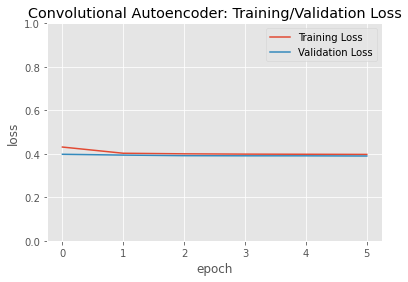

In [0]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Convolutional Autoencoder: Training/Validation Loss")
plt.legend()
plt.ylim(0, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

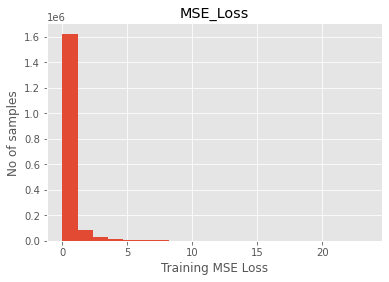

In [0]:
# MSE loss
X_pred = conv.predict(X)

train_mse_loss = np.mean(np.power(X_pred - X,2), axis=1)
train_mse_loss = train_mse_loss.reshape((-1))

plt.hist(train_mse_loss, bins=20)
plt.title('MSE_Loss')
plt.xlabel("Training MSE Loss")
plt.ylabel("No of samples")
plt.show()

In [0]:
A, l = generate_all_testing(tsf_comp_processed,wsize)
# A, l = generate_single_testing_normal(tsf,window,whichnormal=3)
# A, l = generate_all_testing(tsf,window)
A_pred = conv.predict(A)
mse = np.mean(np.power(A - A_pred, 2), axis=1)
ms = mse_sum(mse)
error_df_test = pd.DataFrame({'Reconstruction_error': ms,'True_class': l})
error_df_test = error_df_test.reset_index()

Number of 1s: 1322
This number should be close to #1s * 14 in tsf_labeled
Number of 0s: 54835

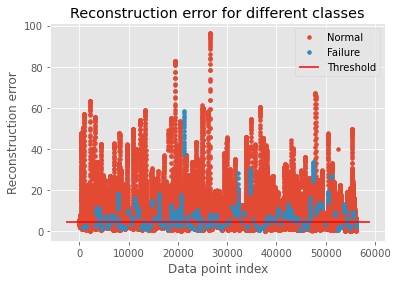

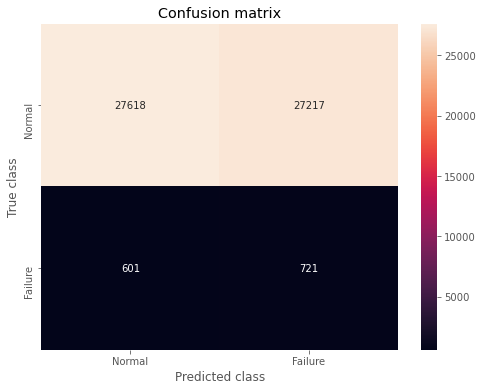

Classification Report for Convolutional Autoencoder:
 precision recall f1-score support

 0 0.98 0.50 0.67 54835
 1 0.03 0.55 0.05 1322

 accuracy 0.50 56157
 macro avg 0.50 0.52 0.36 56157
weighted avg 0.96 0.50 0.65 56157


F1 Score:
[0.66506129 0.0492823 ]

In [0]:
threshold_fixed = 4.7
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Failure" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();
classes = ['Normal','Failure']
y_pred = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print('\nClassification Report for Convolutional Autoencoder:')
print(classification_report(error_df_test.True_class, y_pred))
print('\nF1 Score:')
print(f1_score(error_df_test.True_class, y_pred, average = None))

### LSTM Autoencoder

In [0]:
# This function needs the shape of the training data.

def create_LSTM_window_tuned(n):
  '''
  param: 
    nfirst - first layer
    nsecond - second layer
    dropout - dropout rate
  '''
#   lstm1 = n['lstm_l1']
#   lstm2 = n['lstm_l2']
  lstm1 = wsize
  lstm2 = wsize/2
#   X, y = generate_s_training(train_data,int(n['window_size']))
  train_shape=X

  model2 = tensorflow.keras.Sequential()
  model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', batch_input_shape=(None, train_shape.shape[1], train_shape.shape[2]), return_sequences=True, name='encoder_1'))
  model2.add(tensorflow.keras.layers.Dropout(rate=n['dropout']))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=False, name='encoder_2'))
  model2.add(tensorflow.keras.layers.RepeatVector(train_shape.shape[1], name='encoder_decoder_bridge'))
  model2.add(tensorflow.keras.layers.Dropout(rate=n['dropout']))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
  model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
  model2.add(tensorflow.keras.layers.TimeDistributed(tensorflow.keras.layers.Dense(train_shape.shape[2])))
  return model2

In [0]:
# This function is taking the input of train_shape
def runLSTM_tune_window(n):
  
  # Log run information with mlflow.tensorflow.autolog()
  mlflow.tensorflow.autolog()
  
  model = create_LSTM_window_tuned(n)
 
  # Select optimizer
  optimizer_call = getattr(tensorflow.keras.optimizers, n["optimizer"])
  optimizer = optimizer_call(learning_rate=n['learning_rate'])
#   optimizer = optimizer_call(learning_rate=0.01)

  # Compile model
  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=["mse"])
  early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0,
                                             mode='auto', baseline=None,restore_best_weights=True)
  
#   X, y = generate_s_training(train_data,int(n['window_size']))
  
  history = model.fit(X, y, validation_split=.2, epochs=int(n['epochs']), verbose=2, callbacks=[early_stop])
#   history = model.fit(X, y, validation_split=.2, epochs=10, verbose=2, callbacks=[early_stop])

  # Evaluate the model
  score = model.evaluate(X, y, verbose=0)
  return {"loss": score[0], "status": STATUS_OK}

In [0]:
#Hyperopt search space
space_LSTM = {
#   "lstm_l1": hp.quniform("lstm_l1", 10, 25, 1),
#   "lstm_l2": hp.quniform("lstm_l2", 1, 10, 1),
#   "window_size": hp.quniform("window_size", 15, 30, 1),
  "epochs": hp.quniform("epochs", 10,100,1),
  "learning_rate": hp.loguniform("learning_rate", -5, 0),
  "dropout": hp.loguniform("dropout", -5, -2),
  "optimizer": hp.choice("optimizer", ["Adadelta", "Adam"])
 }

In [0]:
spark_trials = SparkTrials()
with mlflow.start_run():
  best_hyperparam_LSTM = fmin(fn=runLSTM_tune_window, 
                         space=space_LSTM, 
                         algo=tpe.suggest,
                         max_evals=30, 
                         trials=spark_trials)
mlflow.end_run()

Because the requested parallelism was None or a non-positive value, parallelism will be set to (28), which is Spark's default parallelism (28), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/30 [00:00<?, ?trial/s, best loss=?] 3%|▎ | 1/30 [23:18<11:15:50, 1398.30s/trial, best loss: 0.9417333602905273] 7%|▋ | 2/30 [23:26<7:37:55, 981.25s/trial, best loss: 0.5306931138038635]  10%|█ | 3/30 [24:10<5:15:02, 700.09s/trial, best loss: 0.5306931138038635] 13%|█▎ | 4/30 [25:07<3:39:46, 507.18s/trial, best loss: 0.5306931138038635] 17%|█▋ | 5/30 [25:13<2:28:40, 356.83s/trial, best loss: 0.5306931138038635] 20%|██ | 6/30 [25:55<1:44:57, 262.39s/trial, best loss: 0.5306931138038635] 23%|██▎ | 7/30 [26:30<1:14:26, 194.21s/trial, best loss: 0.21387168765068054] 27%|██▋ | 8/30 [28:13<1:01:11, 166.88s/trial, best loss: 0.21387168765068054] 30%|███ | 9/30 [31:31<1:01:36, 176.00s/trial, best loss: 0.11939175426959991] 33%|███▎ | 10/30 [32:48<48:47, 146.35s/trial, best loss: 0.10697511583566666]  37%|███▋ | 11/30 [34:08<40:02, 126.47s/trial, best loss: 0.10697511583566666] 40%|████ | 12/30 [35:45<35:17, 117.66s/trial, best loss: 0.10697511583566666] 43%|████▎ | 13/30 [36:11<25:33, 90.20s/trial, best loss: 0.1036272868514061]  47%|████▋ | 14/30 [36:43<19:24, 72.79s/trial, best loss: 0.10301630198955536] 50%|█████ | 15/30 [38:11<19:21, 77.41s/trial, best loss: 0.10058033466339111] 53%|█████▎ | 16/30 [42:44<31:42, 135.91s/trial, best loss: 0.09224346280097961] 57%|█████▋ | 17/30 [44:29<27:26, 126.67s/trial, best loss: 0.09224346280097961] 60%|██████ | 18/30 [53:03<48:34, 242.86s/trial, best loss: 0.09224346280097961] 63%|██████▎ | 19/30 [53:34<32:52, 179.31s/trial, best loss: 0.09224346280097961] 67%|██████▋ | 20/30 [57:06<31:31, 189.18s/trial, best loss: 0.09224346280097961] 70%|███████ | 21/30 [59:50<27:15, 181.67s/trial, best loss: 0.09224346280097961] 73%|███████▎ | 22/30 [1:07:04<34:17, 257.20s/trial, best loss: 0.09224346280097961] 77%|███████▋ | 23/30 [1:07:24<21:42, 186.04s/trial, best loss: 0.09224346280097961] 80%|████████ | 24/30 [1:11:40<20:42, 207.10s/trial, best loss: 0.09224346280097961] 83%|████████▎ | 25/30 [1:25:38<33:01, 396.31s/trial, best loss: 0.09224346280097961] 87%|████████▋ | 26/30 [1:25:59<18:54, 283.73s/trial, best loss: 0.09224346280097961] 90%|█████████ | 27/30 [1:32:27<15:45, 315.12s/trial, best loss: 0.09224346280097961] 93%|█████████▎| 28/30 [1:37:16<10:14, 307.37s/trial, best loss: 0.09224346280097961] 97%|█████████▋| 29/30 [1:44:12<05:39, 339.78s/trial, best loss: 0.09224346280097961]100%|██████████| 30/30 [2:52:30<00:00, 1467.25s/trial, best loss: 0.09224346280097961]100%|██████████| 30/30 [2:52:30<00:00, 345.01s/trial, best loss: 0.09224346280097961] 
Total Trials: 30: 30 succeeded, 0 failed, 0 cancelled.

In [0]:
import hyperopt
print(hyperopt.space_eval(space_LSTM, best_hyperparam_LSTM))

{'dropout': 0.012172241956202918, 'epochs': 74.0, 'learning_rate': 0.012967795805191192, 'optimizer': 'Adam'}

Epoch 1/74
2450/2450 - 143s - loss: 0.2422 - mse: 0.2422 - val_loss: 0.1690 - val_mse: 0.1690
Epoch 2/74
2450/2450 - 134s - loss: 0.1330 - mse: 0.1330 - val_loss: 0.1316 - val_mse: 0.1316
Epoch 3/74
2450/2450 - 134s - loss: 0.1180 - mse: 0.1180 - val_loss: 0.1218 - val_mse: 0.1218
Epoch 4/74
2450/2450 - 134s - loss: 0.1092 - mse: 0.1092 - val_loss: 0.1175 - val_mse: 0.1175
Epoch 5/74
2450/2450 - 134s - loss: 0.1046 - mse: 0.1046 - val_loss: 0.1167 - val_mse: 0.1167
Epoch 6/74
2450/2450 - 133s - loss: 0.1018 - mse: 0.1018 - val_loss: 0.1102 - val_mse: 0.1102
Epoch 7/74
2450/2450 - 134s - loss: 0.0990 - mse: 0.0990 - val_loss: 0.1106 - val_mse: 0.1106
Epoch 8/74
2450/2450 - 134s - loss: 0.0976 - mse: 0.0976 - val_loss: 0.1040 - val_mse: 0.1040
Epoch 9/74
2450/2450 - 133s - loss: 0.0959 - mse: 0.0959 - val_loss: 0.1126 - val_mse: 0.1126
Epoch 10/74
2450/2450 - 134s - loss: 0.1005 - mse: 0.1005 - val_loss: 0.1170 - val_mse: 0.1170
Epoch 11/74
2450/2450 - 134s - loss: 0.0987 - mse: 0.0987 - val_loss: 0.1043 - val_mse: 0.1043
Epoch 12/74
2450/2450 - 133s - loss: 0.0945 - mse: 0.0945 - val_loss: 0.1040 - val_mse: 0.1040
Epoch 13/74
2450/2450 - 134s - loss: 0.0931 - mse: 0.0931 - val_loss: 0.0994 - val_mse: 0.0994

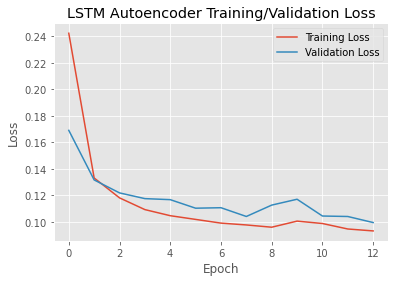

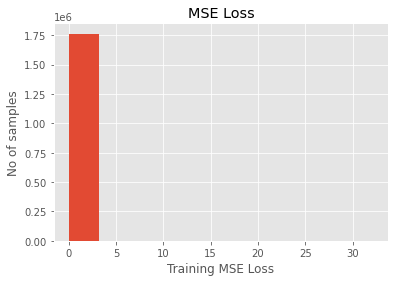

In [0]:
tsf = train_data
dropout = 0.012172241956202918
window = wsize
train_shape = X
optimizer='Adam'
epochs= 74
lstm1 = wsize
lstm2 = wsize/2
learning_rate = 0.012967795805191192

model2 = tensorflow.keras.Sequential()
model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', batch_input_shape=(None, train_shape.shape[1], train_shape.shape[2]), return_sequences=True, name='encoder_1'))
model2.add(tensorflow.keras.layers.Dropout(rate=dropout))
model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=False, name='encoder_2'))
model2.add(tensorflow.keras.layers.RepeatVector(train_shape.shape[1], name='encoder_decoder_bridge'))
model2.add(tensorflow.keras.layers.Dropout(rate=dropout))
model2.add(tensorflow.keras.layers.LSTM(int(lstm2), kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
model2.add(tensorflow.keras.layers.LSTM(int(lstm1), kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
model2.add(tensorflow.keras.layers.TimeDistributed(tensorflow.keras.layers.Dense(train_shape.shape[2])))

optimizer_call = getattr(tensorflow.keras.optimizers, optimizer)
optimizer = optimizer_call(learning_rate=learning_rate)

# Compile model
model2.compile(loss="mse",
              optimizer=optimizer,
              metrics=["mse"])
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0,
                                           mode='auto', baseline=None,restore_best_weights=True)

history = model2.fit(X, y, validation_split=.2, epochs=epochs, verbose=2, callbacks=[early_stop])
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("LSTM Autoencoder Training/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
# MSE loss
X_pred = model2.predict(X)
train_mse_loss = np.mean(np.power(X_pred - y,2), axis=1)
train_mse_loss = train_mse_loss.reshape((-1))

plt.hist(train_mse_loss, bins=10)
plt.title("MSE Loss")
plt.xlabel("Training MSE Loss")
plt.ylabel("No of samples")
plt.show()

In [0]:
A, l = generate_all_testing(tsf_comp_processed,wsize)
# A, l = generate_single_testing_normal(tsf,window,whichnormal=3)
# A, l = generate_all_testing(tsf,window)
A_pred = model2.predict(A)
mse = np.mean(np.power(A - A_pred, 2), axis=1)
ms = mse_sum(mse)
error_df_test = pd.DataFrame({'Reconstruction_error': ms,'True_class': l})
error_df_test = error_df_test.reset_index()

Number of 1s: 1322
This number should be close to #1s * 14 in tsf_labeled
Number of 0s: 54835

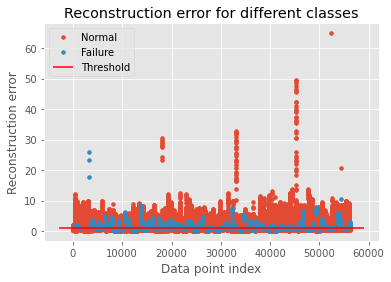

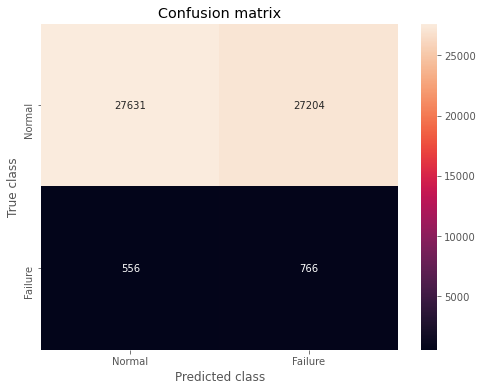

Classification Report for LSTM Autoencoder:
 precision recall f1-score support

 0 0.98 0.50 0.67 54835
 1 0.03 0.58 0.05 1322

 accuracy 0.51 56157
 macro avg 0.50 0.54 0.36 56157
weighted avg 0.96 0.51 0.65 56157


F1 Score:
[0.6656308 0.05230097]

In [0]:
threshold_fixed = 1.16
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Failure" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();
classes = ['Normal','Failure']
y_pred = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print('\nClassification Report for LSTM Autoencoder:')
print(classification_report(error_df_test.True_class, y_pred))
print('\nF1 Score:')
print(f1_score(error_df_test.True_class, y_pred, average = None))